# Computation of random walk for cell nucleus. Viscosity model

The dynamic equation 
$$
m\frac{\text{d}{u}}{\text{d}t} = F_R - 6\pi\mu_\text{ef} Ru \tag{1}
$$ 
is solved, where $F_R$ is the random force due to the cell wall movement and $\mu_\text{ef} = k_\mu \mu$ is the effective viscosity, modified due to the wall proximity.

This equation is numericaly integrated, with first order finite differences, considering that $F_R$ and $k_\mu$ are constant in $\delta t$ giving 
$$
u_{i} = \frac{F_R}{\beta} - \left(\frac{F_R}{\beta} - u_{i-1}\right)\exp\left(-\frac{\beta}{m}\delta t \right) \tag{4} 
$$
for the velocity, with $\beta = 6\pi\mu k_\mu R$, and
$$
x_{i} = x_{i-1}  + \frac{F_R}{\beta}\delta t
+\frac{m}{\beta} \left(u_{i-1} - \frac{F_R}{\beta} \right)\left[1- \exp\left(-\frac{\beta}{m}\delta t \right)\right] $$
for the position.


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, notebook

In [23]:
# Radius of large sphere (m)
R2 = 3.5e-5 
# viscosity of fluid (Pa.s)
mu = 3.43
# Densityof fluid and particle (Kg/m^3)
rho = 1000
# Wall velocity (m/s)
U = 5e-5

In [24]:
def logistic(xi,C,xi_0):
    return 1/(1+np.exp(-C*(xi-xi_0)))
def th_k_mu(k,xi):
    k_mu = 1/(1-k)**2*(2*k*(1-k)/((1-k)**2-xi**2)+0.2*(1-7*k+k**2)*np.log10(k**2/((1-k)**2-xi**2)))
    return k_mu,1+9/8*k/(1-xi)
def k_mu_func(k,xi):
    C = 2.67/k**0.43
    xi_0n = 0.25/k**0.60
    xi_0f = 1.2-11.7*k
    k_mu_th = th_k_mu(k,xi)
    return k_mu_th[1]*(1-logistic(xi,C,xi_0n))+k_mu_th[0]*logistic(xi,C,xi_0f)
def Fr_func(k,xi):
    return (0.3+2.43*k)*np.abs(np.tan(np.pi/2*xi/(1-k)))**(0.35+1.56*k)

In [25]:
# Random walk (True) or uniform wall velocity (False)
random = True ### <-- EDIT
# diameter of microsphere, in microns
d = 5  ### <-- EDIT
# Radius of microsphere (m)
R = d/2*1e-6
# relative curvature
k = R/R2
# microsphere mass (Kg)
m = 4/3*np.pi*rho*R**3
# Reference force. Based on Stokes with all velocity
F_ref = 6*np.pi*mu*R*U
#
#
# Numerical data
#
# Delta time for numerical computation (s)
delta_t = 1e-3 ### <-- EDIT
# Periode of wall movement (s)
T = 0.15 ### <-- EDIT
# Number of iterations in a wall movement cycle 
iT = int(T/delta_t) 
# Duty time for wall velocity (time in wich wall is moving)
Tf = 0.003 ### <-- EDIT
# Number of cycles movements
Nc = 100000 ### <-- EDIT
# Final time of simulation
t_final = Nc*T
# Results saving time (s)
t_w = 0.5 ### <-- EDIT
# Array of times for results
t = np.arange(0,t_final,t_w)
# Initialization of positions and velocities of microsphere
x = np.zeros(t.size)
u = np.zeros(t.size)
x[0] = 0.7*R2 ### <-- EDIT
u[0] = 0
# Initialization for computation loop
xi = x[0]
ui = u[0]
# To save viscosity parameter and force
k_mu = np.zeros(t.size)
Fr = np.zeros(t.size)
# Computation loop
sign = 1 # sign of force (to change t in each cyce)
itw = 0 # output iteration
for ic in notebook.tqdm(range(0,Nc),desc='Progress for {} microns: '.format(d)):
    # Force computation
    Fuerza_media = Fr_func(k,xi/R2)*F_ref
    if random:
        amplitud = sign*np.random.normal(Fuerza_media,Fuerza_media/4)
    else:
        amplitud = sign*Fuerza_media
    for tc in (range(0,iT)):
        tii = tc*delta_t # time inside the cycle (for force computation)
        if (tii < Tf):
            Fri = amplitud
            Fri_keep = Fri # For the sake of visualization
        else:
            Fri = 0.0
        xold = xi
        uold = ui
        k_mui = k_mu_func(k,xi/R2)
        beta = 6*np.pi*mu*R*k_mui
        ui = Fri/beta + (uold - Fri/beta)*np.exp(-beta*delta_t/m)
        xi = xold + Fri/beta*delta_t + m/beta*(uold - Fri/beta)*(1- np.exp(-beta*delta_t/m))
        # Keep the data
        i = ic * iT + tc
        ti = i*delta_t
        if (i == int(itw*t_w/delta_t)):
            u[itw] = ui
            x[itw] = xi
            k_mu[itw] = k_mui
            Fr[int(itw)] = Fri_keep
            itw += 1
    sign = -sign # Change the sign of force for next cycle

Progress for 5 microns:   0%|          | 0/100000 [00:00<?, ?it/s]

Text(0, 0.5, '$\\xi$')

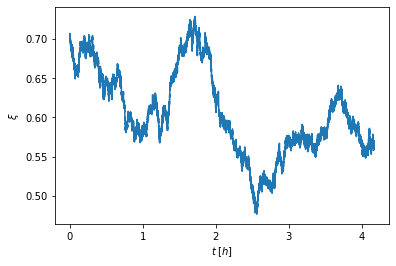

In [26]:
plt.plot(t/3600,x/R2)
plt.xlabel(r'$t\;[h]$')
plt.ylabel(r'$\xi$')